<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/Navec_CNN_remove_stopwords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet

In [33]:
import wget
import os
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
from navec import Navec

# **Get cleaned dataset**

In [34]:
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU_remove_stopwords.csv'

PATH_CLEANED_DATASET = 'data_cleaned_RU_remove_stopwords.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [35]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
10494,страна расположиться база хотеть вернуться ссс...,0
5745,учёный знать,0
2988,запустить патока пердун старый,1
12486,оформлять дебетовый карта рок банк привезти оф...,0
230,бандос авторитетный человек который доверять о...,0
1289,малыш сын свой звать поучить логика негативный...,1
3695,панический атака всд очень частый спутник проя...,1
5157,красиво получиться выглядеть легко впечатление...,0
6743,дорого ездить например каждый выходной км горо...,0
3297,недрачибельный жирный жопа фууа ловить минусец,1


In [36]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 5943
min : 2
mean : 127.40542980141647


max:  717
min:  1
mean:  16.417372587140676


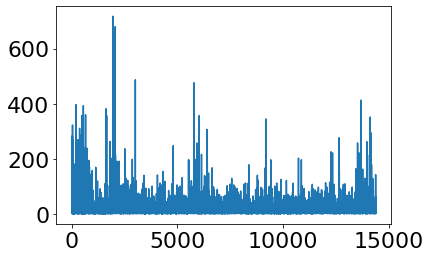

In [37]:
import statistics

print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [38]:
sentences = df.comment.values
labels = df.toxic.values

**Split**

In [39]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)

In [40]:
X_train.shape

(11521,)

In [41]:
type(X_train)

numpy.ndarray

In [42]:
from navec import Navec

url = 'https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar'
PATH_NAVEC = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

if not os.path.exists(PATH_NAVEC):
    wget.download(url)
navec = Navec.load(PATH_NAVEC)

In [43]:
NAVEC_UNK= '<unk>'
NAVEC_PAD= '<pad>'
DIMENSION_EMBEDDING=navec.get('<unk>').shape[0]

In [44]:
def vectorize_sentence(sentence: str, vectorizer=navec,unc_token =NAVEC_UNK, pad_token = NAVEC_PAD, max_sequence_length=30) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [navec.get(t, navec[unc_token]) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [navec[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

In [45]:
# получить длину(количество слов) отзывов в 75% датасета
sequence_length=int(round(np.percentile(list(map(lambda sentence: len(sentence.split()), X_train)), 75)))

In [46]:
sequence_length

18

In [47]:
navec.get('<unk>').shape[0]

300

In [48]:
X_train = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_train.flatten()
    )
))

X_test = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=navec,
        unc_token =NAVEC_UNK,
        pad_token = NAVEC_PAD,
        max_sequence_length=sequence_length),
    X_test.flatten()
    )
))


In [49]:
X_train.shape

(11521, 18, 300)

**Build RNN model**

Model: "Glove-Navec_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_47 (Conv1D)          (None, 16, 256)           230656    
                                                                 
 gru_9 (GRU)                 (None, 128)               148224    
                                                                 
 dropout_59 (Dropout)        (None, 128)               0         
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 dropout_60 (Dropout)        (None, 64)                0         
                                                                 
 dense_62 (Dense)            (None, 1)                 65        
                                                                 
Total params: 387,201
Trainable params: 387,201
Non

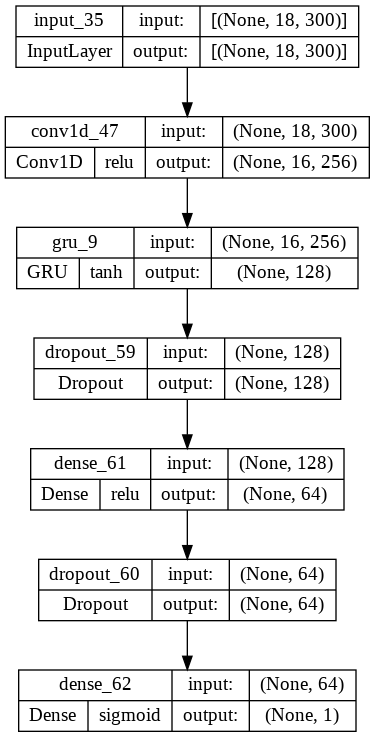

In [388]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Conv1D,GlobalMaxPool1D,SpatialDropout1D,GRU
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

SEED = 42
SPLIT = 0.2
EPOCHS = 50
BATCH_SIZE = 512
MODEL_NAME = 'Glove-Navec_CNN'

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    GRU(128, dropout=0.3, recurrent_dropout=0.1),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [389]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=7,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=SPLIT,
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/50
18/18 [==============================] - 6s 114ms/step - loss: 0.7032 - tp: 388.0000 - fp: 423.0000 - tn: 5737.0000 - fn: 2668.0000 - accuracy: 0.6646 - precision: 0.4784 - recall: 0.1270 - auc: 0.5678 - prc: 0.3996 - val_loss: 0.6290 - val_tp: 742.0000 - val_fp: 929.0000 - val_tn: 587.0000 - val_fn: 47.0000 - val_accuracy: 0.5766 - val_precision: 0.4440 - val_recall: 0.9404 - val_auc: 0.7974 - val_prc: 0.6253
Epoch 2/50
18/18 [==============================] - 1s 47ms/step - loss: 0.4607 - tp: 2558.0000 - fp: 1605.0000 - tn: 4555.0000 - fn: 498.0000 - accuracy: 0.7718 - precision: 0.6145 - recall: 0.8370 - auc: 0.8718 - prc: 0.7832 - val_loss: 0.3708 - val_tp: 633.0000 - val_fp: 181.0000 - val_tn: 1335.0000 - val_fn: 156.0000 - val_accuracy: 0.8538 - val_precision: 0.7776 - val_recall: 0.8023 - val_auc: 0.9115 - val_prc: 0.8471
Epoch 3/50
18/18 [==============================] - 1s 47ms/step - loss: 0.3209 - tp: 2659.0000 - fp: 765.0000 - tn: 5395.0000 - fn: 397.0000 - accu

**Save model**

In [390]:
model.save(MODEL_NAME)

In [391]:
pred = model.predict(X_test).flatten()

91/91 [==============================] - 1s 6ms/step


In [392]:
pred

array([0.9906317 , 0.9693822 , 0.0081869 , ..., 0.00400512, 0.6673287 ,
       0.03491821], dtype=float32)

In [393]:
pred

array([0.9906317 , 0.9693822 , 0.0081869 , ..., 0.00400512, 0.6673287 ,
       0.03491821], dtype=float32)

In [394]:
threshold =0.5
pred = np.where(pred<threshold,0,1)

In [395]:
pred

array([1, 1, 0, ..., 0, 1, 0])

In [396]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 88.72 %
Recall: 83.23 %
Precision: 83.49 %
F1-score: 83.36 % 

True Negatives:  1742
False Positives:  161
False Negatives:  164
True Positives:  814


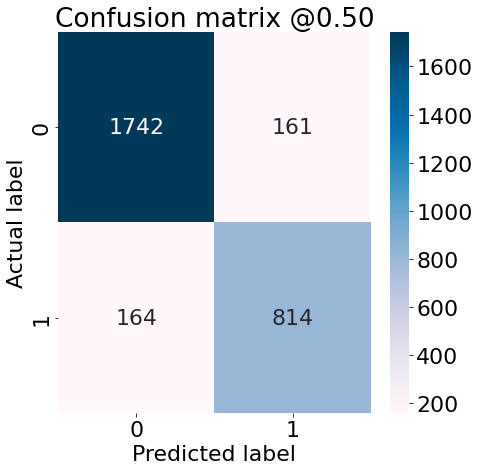

In [397]:
plot_cm(y_test, pred)

In [398]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

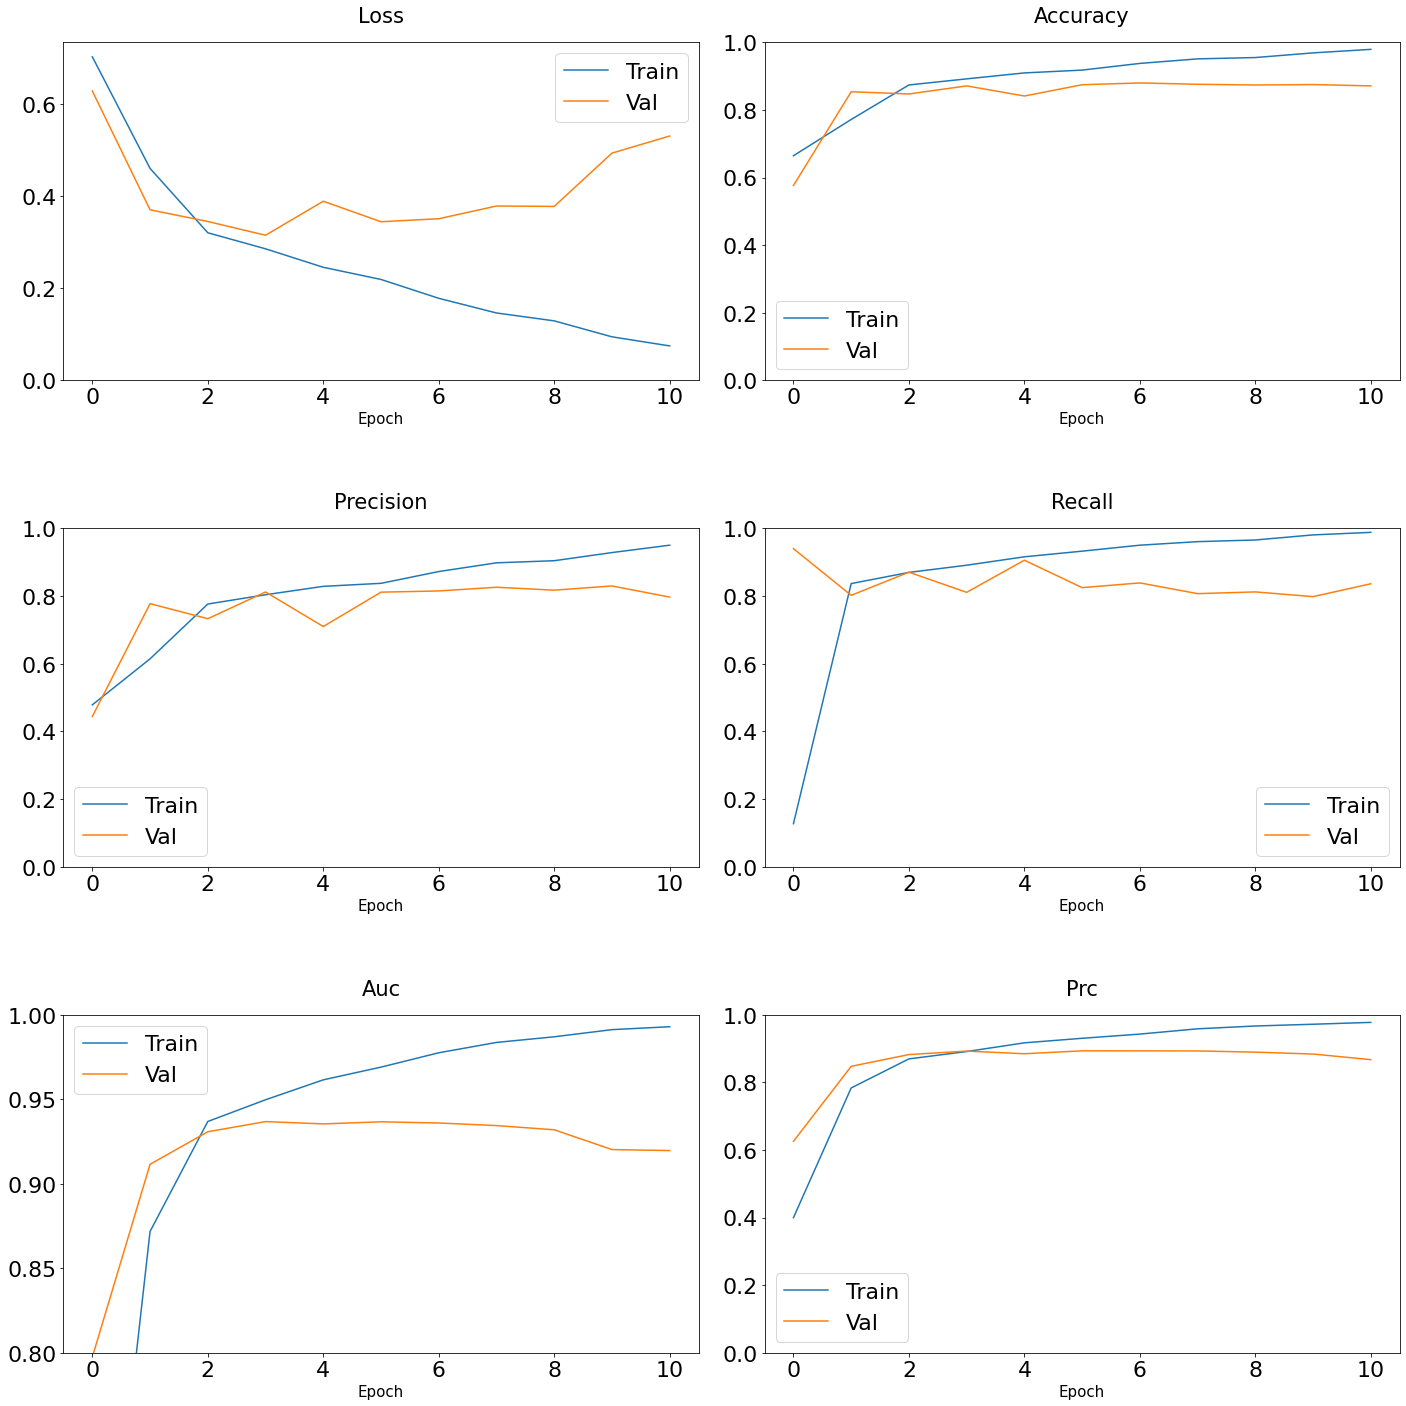

In [399]:
plot_metrics(history)

**Отобразим ROC - кривую**

91/91 [==============================] - 1s 6ms/step
: ROC AUC=0.943


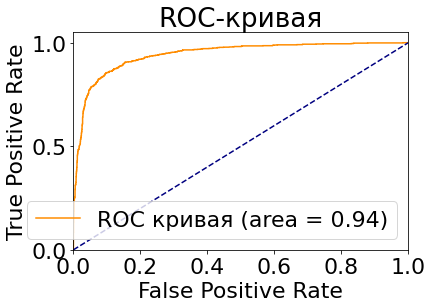

In [400]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# сохраняем вероятности только для положительного исхода
lr_probs = model.predict(X_test).flatten()
threshold =0.5
pred = np.where(pred<threshold,0,1)
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print(': ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()